# Exercice 1 - NACA 2412

## Experimental data
Les données du graphique page 136 ont été numérisées. On peut les tracer pour vérifier, l'option retina c'est pour améliorer la qualité des tracés de ce notebook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

In [2]:
data_cl = np.loadtxt('Cl_NACA_2412.csv',skiprows=1,delimiter=',')
data_cm = np.loadtxt('cm_c4_NACA_2412.csv',skiprows=1,delimiter=',')

Mes extractions sont un peu bruitées, on va prendre une interpolation linéaire du coefficient du $c_l$ et sur $c_{m,c/4}$ selon des droites entre $[-10,12]$ degrés. On a montré par la théorie que c'était le cas pour $c_l$ avec la théorie des profils minces. Pour le $c_{m,c/4}$ on obtient une constante (qui dépend de la cambrure) avec la théorie des profils minces, mais on a une variation (faible) mesurée expérimentalement.

In [3]:
# Cl linear fit
aoa_keep = (data_cl[:,0] >= -10) * (data_cl[:,0] <= 12) # restriction of the linear domain
p_cl = np.polyfit(data_cl[aoa_keep,0],data_cl[aoa_keep,1],1)
cl_intp_fct = np.poly1d(p_cl)
# Cm linear fit
aoa_keep = (data_cm[:,0] >= -10) * (data_cm[:,0] <= 12) # restriction of the linear domain
p_cm = np.polyfit(data_cm[aoa_keep,0],data_cm[aoa_keep,1],1) 
cm_intp_fct = np.poly1d(p_cm)

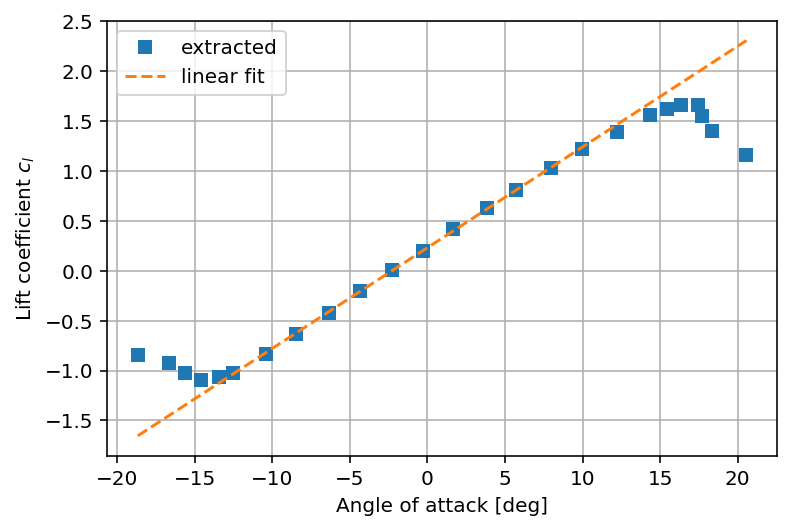

In [4]:
plt.plot(data_cl[:,0],data_cl[:,1],'s',label='extracted');
plt.plot(data_cl[:,0],cl_intp_fct(data_cl[:,0]),label='linear fit',linestyle='dashed')
plt.xlabel('Angle of attack [deg]');
plt.ylabel('Lift coefficient $c_l$');
plt.grid();
plt.legend();
plt.savefig('coeff_cl_interp.png');

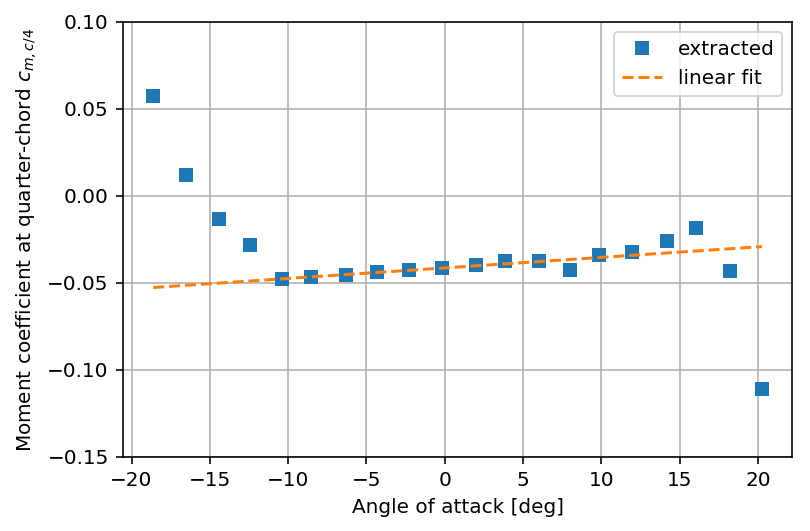

In [5]:
plt.plot(data_cm[:,0],data_cm[:,1],'s',label='extracted');
plt.plot(data_cm[:,0],cm_intp_fct(data_cm[:,0]),label='linear fit',linestyle='dashed')
plt.xlabel('Angle of attack [deg]');
plt.ylabel('Moment coefficient at quarter-chord $c_{m,c/4}$');
plt.ylim(-0.15,0.1);
plt.grid();
plt.legend();
plt.savefig('coeff_cm_interp.png');

Ok on est prêt pour faire la question 1 et 2 de l'exercice. Dans ce notebook on ne fera que les applications numériques. Il accompagne le corrigé en pdf.

In [6]:
print('Coefficient de portance à 4 deg: {0:.3f}'.format(cl_intp_fct(4.)))
print('Coefficient de moment au quart de corde à 4 deg: {0:.3f}'.format(cm_intp_fct(4.)))

Coefficient de portance à 4 deg: 0.636
Coefficient de moment au quart de corde à 4 deg: -0.039


## Question 1
Applications numériques

In [7]:
chord = 0.6
Vinf  = 50.
rho   = 1.23
L = 0.5 * rho * Vinf**2 * chord * cl_intp_fct(4.)
M = 0.5 * rho * Vinf**2 * chord**2 * cm_intp_fct(4.)
print('L={0:.3f}'.format(L))
print('M={0:.3f}'.format(M))

L=586.319
M=-21.642


## Question 2
Applications numériques

In [8]:
chord = 2.
Vinf  = 50.
rho   = 1.23
L     = 1353.
cl = L /(0.5* rho * Vinf**2 * chord)
print('cl={0:.3f}'.format(cl))
aoa = (cl - p_cl[1])/p_cl[0]
print('aoa={0:.3f} deg'.format(aoa))

cl=0.440
aoa=2.065 deg


## Question 4
On utilise le module de calcul symbolique `sympy` pour calculer les intégrales.

In [9]:
import sympy as sb
sb.init_printing()

On définit les paramètres et les variables qui apparaissent dans les équations (16), (19) et (20).

In [10]:
theta = sb.Symbol('theta')
aoa   = sb.Symbol('alpha')
m     = 0.02
p     = 0.4

L'angle de Glauert qui correspond au raccordement entre les deux polynômes qui définissent $\eta_C$.

In [11]:
theta_c = np.arccos(1.-2.*p)
print('theta_c = {0:.3f} rad = {1:.2f} deg'.format(theta_c,theta_c*180./np.pi))

theta_c = 1.369 rad = 78.46 deg


On définit la dérivée de $\eta_C$ que l'on voudra intégrer pour obtenir les $A_i$.

In [12]:
pente_C_piece1 = m/p**2 * ((2*p -1)+sb.cos(theta))
pente_C_piece1

In [13]:
pente_C_piece2 = m/(1-p)**2 * ((2*p -1)+sb.cos(theta))
pente_C_piece2

On calcule $A_0$

In [14]:
A0=aoa -1/sb.pi * (sb.integrate(pente_C_piece1,(theta,0,theta_c))+sb.integrate(pente_C_piece2,(theta,theta_c,sb.pi)))
sb.N(A0.subs([(m, 0.02), (p, 0.4)]))

On calcule $A_1$

In [15]:
A1 = 2/sb.pi *(sb.integrate(pente_C_piece1 * sb.cos(theta),(theta,0,theta_c)) + sb.integrate(pente_C_piece2 * sb.cos(theta),(theta,theta_c,sb.pi)))
sb.N(A1)

On évalue pour avoir l'abscisse $A_0+A_1/2=\alpha -\alpha_{L=0}$.

In [16]:
sb.N((A0+A1/2))

In [17]:
np.rad2deg(0.0362546844210347)

On a obtenu des valeurs expérimentales extraites $\alpha_{L=0}$ directement en degrés : 

In [18]:
-(p_cl[1]/p_cl[0])

On vérifie la précision du résultat obtenu.

In [19]:
cl = 2* sb.pi * (A0+A1/2)
cl_theorical = sb.lambdify(aoa,cl,'numpy')

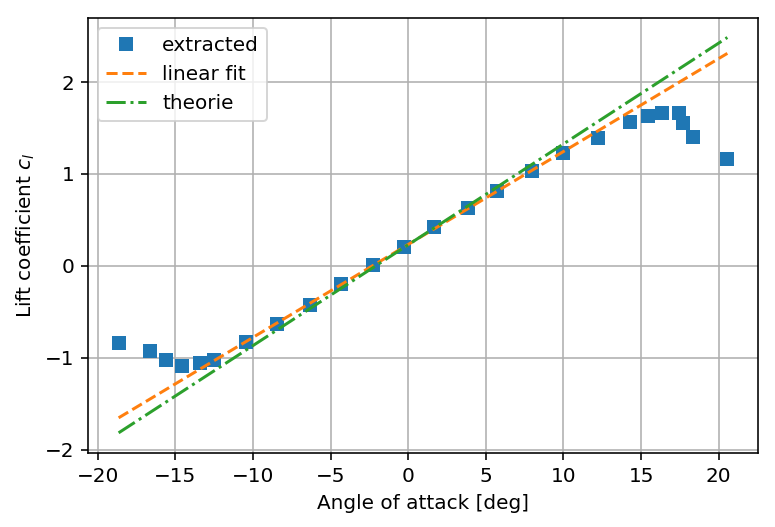

In [20]:
plt.plot(data_cl[:,0],data_cl[:,1],'s',label='extracted');
plt.plot(data_cl[:,0],cl_intp_fct(data_cl[:,0]),label='linear fit',linestyle='dashed')
plt.plot(data_cl[:,0],cl_theorical(np.deg2rad(data_cl[:,0])),label='theorie',linestyle='-.')
plt.xlabel('Angle of attack [deg]');
plt.ylabel('Lift coefficient $c_l$');
plt.grid();
plt.legend();
plt.savefig('coeff_cl_interp.png',dpi=300);

La pente théorique est légèrement plus importante que la pente expérimentale.

$c_L$ à $4^\circ$ (à comparer avec Q1)

In [21]:
cl_theorical(4*np.pi/180.)

$c_L$ à $2.065^\circ$ (à comparer avec Q2)

In [22]:
cl_theorical(2.065*np.pi/180.)

In [23]:
A2 = 2/sb.pi *(sb.integrate(pente_C_piece1 * sb.cos(2.*theta),(theta,0,theta_c)) + sb.integrate(pente_C_piece2 * sb.cos(2.*theta),(theta,theta_c,sb.pi)))
sb.N(A2)

In [24]:
cm_theorie = sb.pi /4* (A2-A1)
sb.N(cm_theorie)

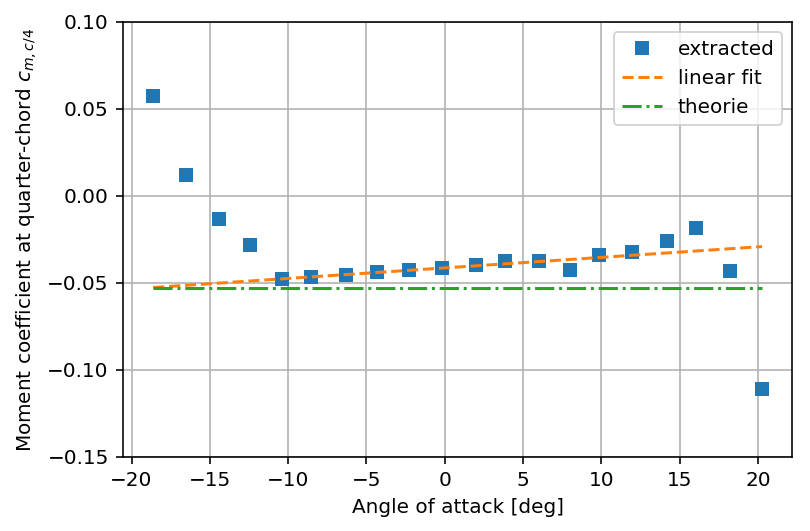

In [25]:
plt.plot(data_cm[:,0],data_cm[:,1],'s',label='extracted');
plt.plot(data_cm[:,0],cm_intp_fct(data_cm[:,0]),label='linear fit',linestyle='dashed')
plt.plot(data_cm[:,0],cm_theorie*np.ones_like(data_cm[:,0]),label='theorie',linestyle='-.')
plt.xlabel('Angle of attack [deg]');
plt.ylabel('Moment coefficient at quarter-chord $c_{m,c/4}$');
plt.ylim(-0.15,0.1);
plt.grid();
plt.legend();
plt.savefig('coeff_cm_interp.png');

In [26]:
A3 = 2/sb.pi *(sb.integrate(pente_C_piece1 * sb.cos(3.*theta),(theta,0,theta_c)) + sb.integrate(pente_C_piece2 * sb.cos(3.*theta),(theta,theta_c,sb.pi)))
sb.N(A3)

In [27]:
A4 = 2/sb.pi *(sb.integrate(pente_C_piece1 * sb.cos(4.*theta),(theta,0,theta_c)) + sb.integrate(pente_C_piece2 * sb.cos(4.*theta),(theta,theta_c,sb.pi)))
sb.N(A4)

In [28]:
A5 = 2/sb.pi *(sb.integrate(pente_C_piece1 * sb.cos(5.*theta),(theta,0,theta_c)) + sb.integrate(pente_C_piece2 * sb.cos(5.*theta),(theta,theta_c,sb.pi)))
sb.N(A5)

Pour évaluer la convergence de la série, on évalue le coefficent de pression en ajoutant un à un les termes de la série.

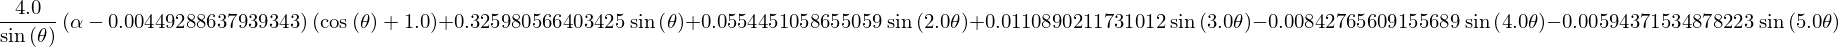

In [29]:
DCp_0 = 4 * (A0 * (1+sb.cos(theta))/ sb.sin(theta)  )
DCp_01 = DCp_0 + 4* A1 * sb.sin(theta) 
DCp_02 = DCp_01 + 4* A2 * sb.sin(2.*theta) 
DCp_03 = DCp_02 + 4* A3 * sb.sin(3.*theta) 
DCp_04 = DCp_03 + 4* A4 * sb.sin(4.*theta) 
DCp_05 = DCp_04 + 4* A5 * sb.sin(5.*theta) 
sb.N(DCp_05)

On se donne une discrétisation du profil $x/c$, et on y applique la transformée de Glauert pour pouvoir évaluer le $\Delta C_p$

In [30]:
DCp_th_0 = sb.lambdify([aoa,theta],DCp_0,'numpy')
DCp_th_01 = sb.lambdify([aoa,theta],DCp_01,'numpy')
DCp_th_02 = sb.lambdify([aoa,theta],DCp_02,'numpy')
DCp_th_03 = sb.lambdify([aoa,theta],DCp_03,'numpy')
DCp_th_04 = sb.lambdify([aoa,theta],DCp_04,'numpy')
DCp_th_05 = sb.lambdify([aoa,theta],DCp_05,'numpy')
xc_discr    = np.linspace(0.02,0.98,100) # on évite 1 car le premier terme diverge
theta_discr = np.arccos(1.-2.*xc_discr)

Pour $\alpha=0$ on a:

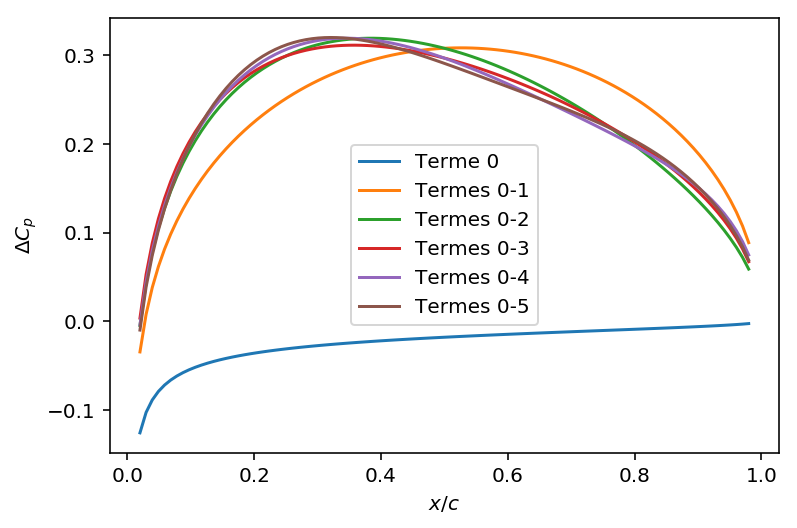

In [31]:
plt.plot(xc_discr,DCp_th_0(0.,theta_discr),label='Terme 0');
plt.plot(xc_discr,DCp_th_01(0.,theta_discr),label='Termes 0-1');
plt.plot(xc_discr,DCp_th_02(0.,theta_discr),label='Termes 0-2');
plt.plot(xc_discr,DCp_th_03(0.,theta_discr),label='Termes 0-3');
plt.plot(xc_discr,DCp_th_04(0.,theta_discr),label='Termes 0-4');
plt.plot(xc_discr,DCp_th_05(0.,theta_discr),label='Termes 0-5');
plt.xlabel('$x/c$');
plt.ylabel('$\Delta C_p$');
plt.legend();
plt.savefig('Convergence_DCp.png',dpi=150);

## Question 5
On définit la pente de la fonction de demi-épaisseur.

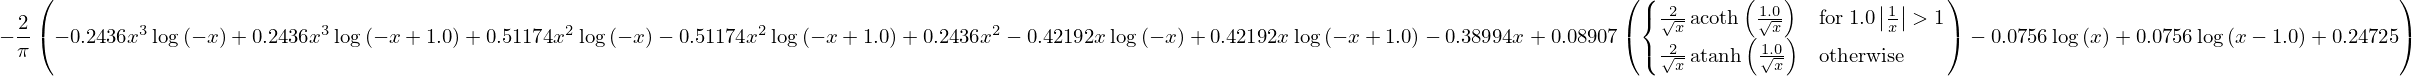

In [33]:
s = sb.Symbol('s')
x = sb.Symbol('x')
pente_T = 0.12/0.2*(0.14845/sb.sqrt(s) -0.126-0.7032*s +0.8529*s**2-0.406*s**3)
Cp = -2/sb.pi * sb.integrate(pente_T/(x-s),(s,0.,1.))
Cp

Beurk, c'est vraiment pas beau... On ne peut pas utiliser lambdify car costh n'existe pas en numpy. On fait donc une boucle d'évaluation dans sympy.

In [34]:
print(Cp)

-2*(-0.2436*x**3*log(-x) + 0.2436*x**3*log(-x + 1.0) + 0.51174*x**2*log(-x) - 0.51174*x**2*log(-x + 1.0) + 0.2436*x**2 - 0.42192*x*log(-x) + 0.42192*x*log(-x + 1.0) - 0.38994*x + 0.08907*Piecewise((2*acoth(1.0/sqrt(x))/sqrt(x), 1.0*Abs(1/x) > 1), (2*atanh(1.0/sqrt(x))/sqrt(x), True)) - 0.0756*log(x) + 0.0756*log(x - 1.0) + 0.24725)/pi


In [35]:
Cp_fct=-2*(0.2436*x**3*sb.log((1.-x)/x) 
           - 0.51174*x**2*sb.log((1.-x)/x ) 
           + 0.2436*x**2 + 0.42192*x*sb.log((1-x )/x)
           - 0.38994*x + 0.08907*(2*sb.acoth(1.0/sb.sqrt(x))/sb.sqrt(x))
           + 0.0756*sb.log((1.0-x)/x) + 0.24725)/sb.pi
Cp_fct_T_eval = np.zeros_like(xc_discr)
for iv,xv in enumerate(xc_discr):
    Cp_fct_T_eval[iv] = np.real(sb.N(Cp_fct.subs(x,xv)))

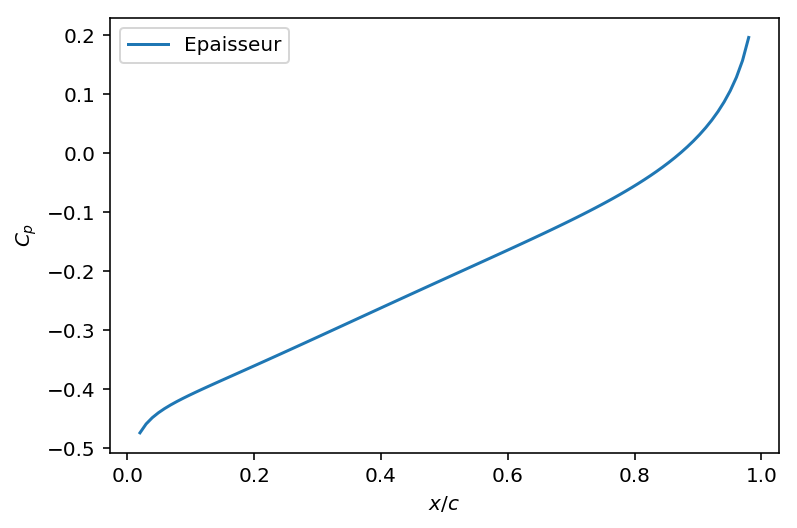

In [36]:
plt.plot(xc_discr,Cp_fct_T_eval,label='Epaisseur');
plt.xlabel('$x/c$');
plt.ylabel('$C_p$');
plt.legend();
plt.savefig('Cp_epaisseur.png',dpi=150);

## Question 8
On somme les $C_p$. À l'extrados, pour le problème portant $C_{p,e}=-\frac{\Delta C_p}{2}$ et à l'intrados $C_{p,i}=\frac{\Delta C_p}{2}$. Pour le problème d'épaisseur les deux sont identiques.

Sans incidence 

In [37]:
data_xfoil_0deg = np.loadtxt('CP_NACA2412_XFOIL_IVISC_ALFA_0.TXT',skiprows=1)

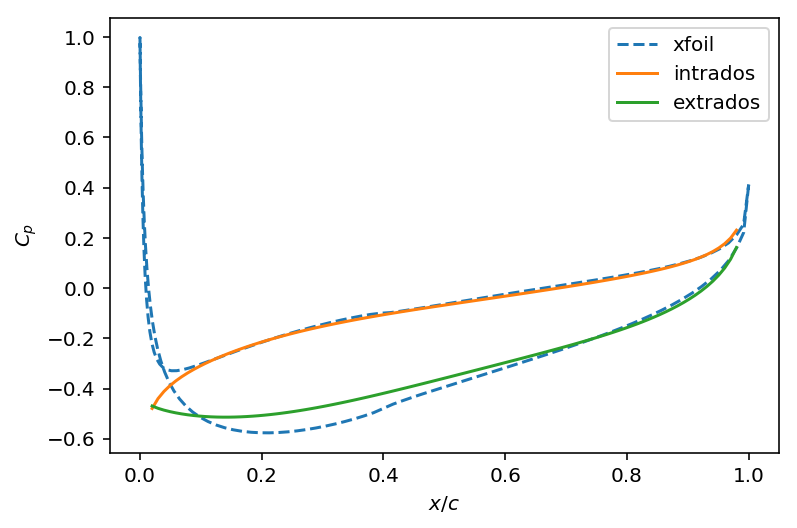

In [38]:
plt.plot(data_xfoil_0deg[:,0],data_xfoil_0deg[:,1],label='xfoil',linestyle='--');
plt.plot(xc_discr,DCp_th_05(0.,theta_discr)/2.+Cp_fct_T_eval,label='intrados');
plt.plot(xc_discr,-DCp_th_05(0.,theta_discr)/2.+Cp_fct_T_eval,label='extrados');
plt.xlabel('$x/c$');
plt.ylabel('$C_p$');
plt.legend();
plt.savefig('Cp_total_0AoA.png',dpi=150);

Plutôt bon ! Sauf au bord d'attaque.

Avec une incidence de $2.5^\circ$

In [39]:
data_xfoil_2_5deg = np.loadtxt('CP_NACA2412_XFOIL_IVISC_ALFA_2.5.TXT',skiprows=1)

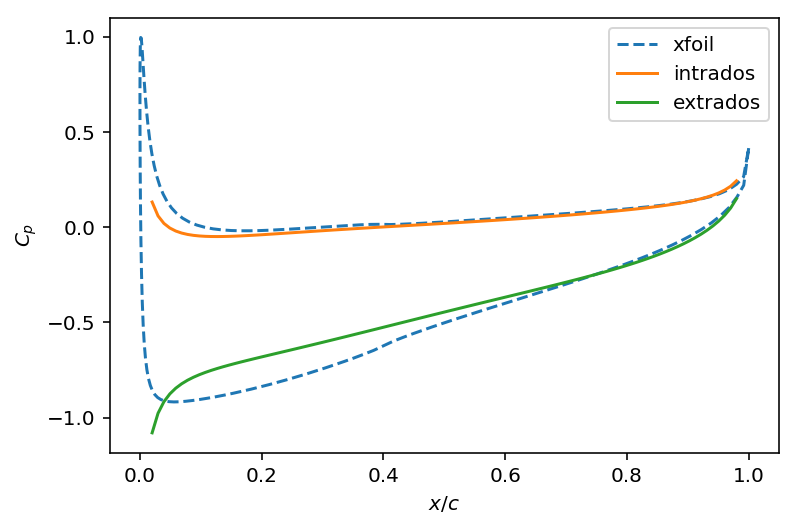

In [40]:
plt.plot(data_xfoil_2_5deg[:,0],data_xfoil_2_5deg[:,1],label='xfoil',linestyle='--');
plt.plot(xc_discr,DCp_th_05(np.deg2rad(2.5),theta_discr)/2.+Cp_fct_T_eval,label='intrados');
plt.plot(xc_discr,-DCp_th_05(np.deg2rad(2.5),theta_discr)/2.+Cp_fct_T_eval,label='extrados');
plt.xlabel('$x/c$');
plt.ylabel('$C_p$');
plt.legend();
plt.savefig('Cp_total_5AoA.png',dpi=150);

À nouveau c'est plutôt bon ! Sauf au bord d'attaque. On peut regarder la partie portance seulement en comparant le $\Delta C_p$. On découpe ci-dessous les profils de `xfoil` en la partie extrados et la partie intrados. Comme les panneaux sont numérotés selon une courbe fermée (bord de fuite vers bord d'attaque extrados, puis bord d'attaque vers bord de fuite intrados), on inverse une des deux parties avant de faire le calcul du $\Delta C_p$.

In [41]:
npanels = data_xfoil_2_5deg.shape[0]
xc_xfoil = data_xfoil_2_5deg[:npanels//2,0]
extrados = data_xfoil_2_5deg[:npanels//2,1]
intrados = data_xfoil_2_5deg[npanels//2:,1][::-1]
DCp_xfoil = intrados-extrados

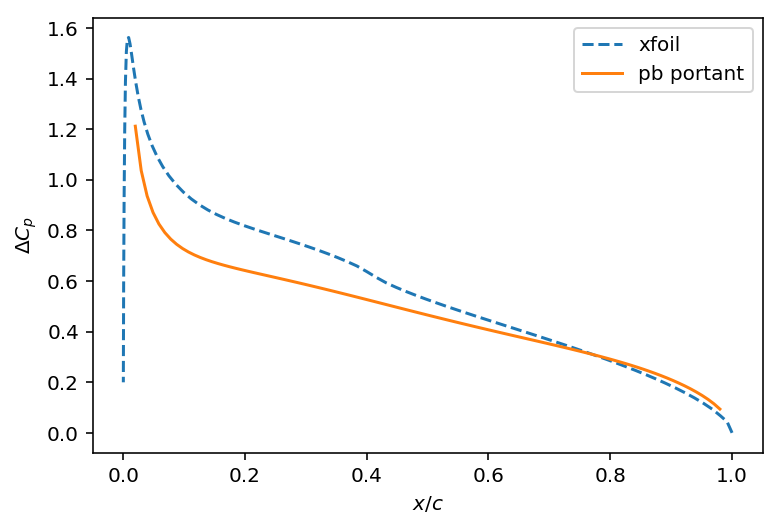

In [42]:
plt.plot(xc_xfoil,DCp_xfoil,label='xfoil', linestyle='--');
plt.plot(xc_discr,DCp_th_05(np.deg2rad(2.5),theta_discr),label='pb portant');
plt.xlabel('$x/c$');
plt.ylabel('$\Delta C_p$');
plt.legend();

Le problème portant de la méthode des petites perturbations donne une bonne distribution de la charge de la charge. C'est une méthode purement analytique qui a été beaucoup utilisée à l'époque où les ordinateurs n'étaient pas disponibles dans tous les bureaux d'ingénieurs. Et les mecs se tapaient les intégrales à la main !
NB: Ils devaient certainement les faire vérifier par leurs assistantes (vous avez vu *Hidden Figures*, j'espère !)